### Ejercicio Práctico - Clase 3 VPC2 - 4Co2021

1) Realizar transfer learning a partir de alguna de las siguientes redes: vgg11, resnet18, convnext_tiny preentrenadas, y entrenar sobre el dataset CIFAR10 contenido en PyTorch. Que puede concluir al compararlos con los resultados obtenidos en el entrenamiento de la tarea 2?

Files already downloaded and verified
Files already downloaded and verified
### Descripción del conjunto de entrenamiento ###
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
### Dimensiones de un ejemplo del dataset ###
(32, 32, 3)
### Descripción del conjunto de evaluación ###
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Label de la imágen 0: 6
Label de la imágen 1: 9
Label de la imágen 2: 9
Label de la imágen 3: 4
Label de la imágen 4: 1
Label de la imágen 5: 1
Label de la imágen 6: 2
Label de la imágen 7: 7
Label de la imágen 8: 8


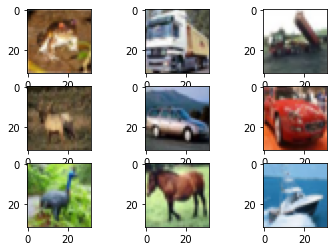

Files already downloaded and verified
Files already downloaded and verified
images-size: torch.Size([128, 3, 32, 32])
out-size: torch.Size([3, 546, 274])


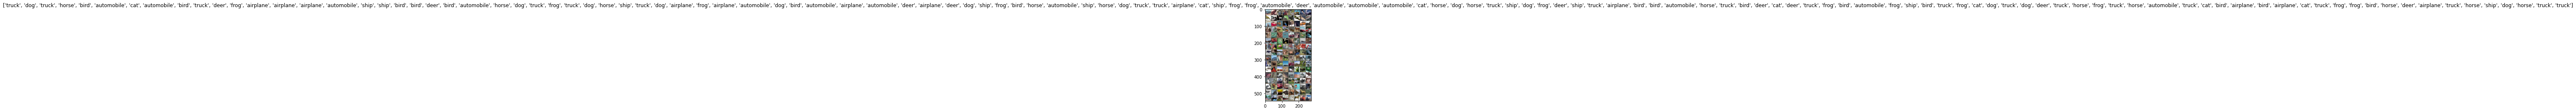

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

batch_size = 128 # probar con 131
learning_rate = 1e-5

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

print("### Descripción del conjunto de entrenamiento ###")
print(train_dataset)
print("### Dimensiones de un ejemplo del dataset ###")
print(np.shape(train_dataset[0][0]))
print("### Descripción del conjunto de evaluación ###")
print(test_dataset)

# Ploteo algunas imagenes del dataset y sus etiquetas
for i in range(9):
  image, label = train_dataset[i]
  plt.subplot(331 + i)
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  print("Label de la imágen {}: {}".format(i, label))

plt.show()


transforms = transforms.Compose([
    #torchvision.transforms.Resize(size=(150, 150)),
    torchvision.transforms.RandomResizedCrop(size=(32, 32), scale=(0.5, 1.0)),
    torchvision.transforms.ColorJitter(saturation=0.08, hue=0.07),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)


#train_dataset2 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms2)





#train_dataset = datasets.ImageFolder(root='C:/Users/Augusto/Documents/GitHub/UBA/1-Raul/Vision-por-Computadora-II Practicas/TP3/fruits-360_dataset/fruits-360/Training', transform=transforms)
#test_dataset = datasets.ImageFolder(root='C:/Users/Augusto/Documents/GitHub/UBA/1-Raul/Vision-por-Computadora-II Practicas/TP3/fruits-360_dataset/fruits-360/Test', transform=transforms)


def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [2]:
net = models.resnet18(pretrained=True)
#net = net.cuda() if device else net
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
use_cuda = 0

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 131)
net.fc = net.fc.cuda() if use_cuda else net.fc

In [4]:
n_epochs = 10
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/10], Step [0/391], Loss: 5.4573
Epoch [1/10], Step [20/391], Loss: 5.2588
Epoch [1/10], Step [40/391], Loss: 5.1745
Epoch [1/10], Step [60/391], Loss: 5.0308
Epoch [1/10], Step [80/391], Loss: 4.8379
Epoch [1/10], Step [100/391], Loss: 4.8460
Epoch [1/10], Step [120/391], Loss: 4.6819
Epoch [1/10], Step [140/391], Loss: 4.6757
Epoch [1/10], Step [160/391], Loss: 4.4493
Epoch [1/10], Step [180/391], Loss: 4.3554
Epoch [1/10], Step [200/391], Loss: 4.0147
Epoch [1/10], Step [220/391], Loss: 4.0054
Epoch [1/10], Step [240/391], Loss: 3.6446
Epoch [1/10], Step [260/391], Loss: 3.8146
Epoch [1/10], Step [280/391], Loss: 3.7338
Epoch [1/10], Step [300/391], Loss: 3.7013
Epoch [1/10], Step [320/391], Loss: 3.4729
Epoch [1/10], Step [340/391], Loss: 3.0498
Epoch [1/10], Step [360/391], Loss: 3.3476
Epoch [1/10], Step [380/391], Loss: 3.1634

train-loss: 4.2221, train-acc: 20.1960
validation loss: 3.0694, validation acc: 43.1400

Improvement-Detected, save-model
Epoch 2

Epoch

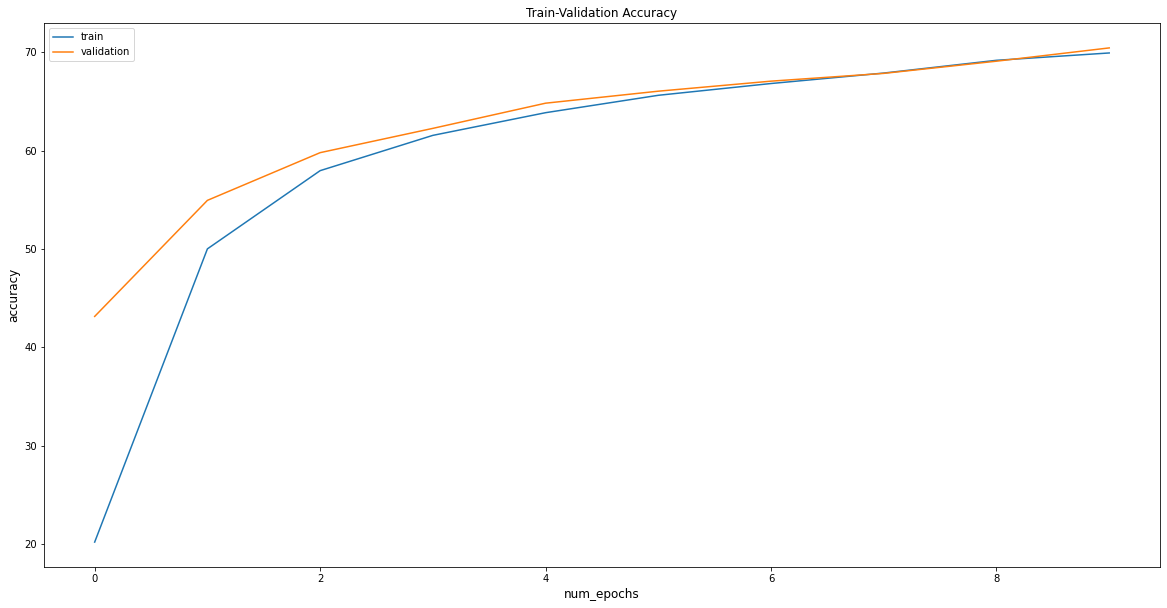

In [5]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

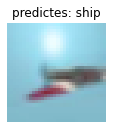

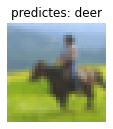

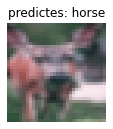

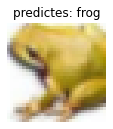

In [6]:
def visualize_model(net, num_images=4):
    images_so_far = 0
   # fig = plt.figure(figsize=(15, 6))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if use_cuda else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()

Conclusión: La precisión obtenida con transfer learning es utilizando Resnet18, aunque las pérdidas dieron un poco mayores (38%). El resultado de transferlearning se obtuvo con 10 epochs, lo que redujo significativamente los tiempos y reitero, la precisión del validation set.

2) Realice el entrenamiento de la misma red seleccionada en el punto 1, sin partir de pesos preentrenados en esta oportunidad y sin congelar capas. A que resultados llega y como los explica?

In [7]:
net = models.resnet18(pretrained=False)
#net = net.cuda() if device else net
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
use_cuda = 0

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

#num_ftrs = net.fc.in_features
#net.fc = nn.Linear(num_ftrs, 131)
#net.fc = net.fc.cuda() if use_cuda else net.fc

In [9]:
n_epochs = 10
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/10], Step [0/391], Loss: 7.1968
Epoch [1/10], Step [20/391], Loss: 6.7339
Epoch [1/10], Step [40/391], Loss: 6.0632
Epoch [1/10], Step [60/391], Loss: 5.1611
Epoch [1/10], Step [80/391], Loss: 4.7763
Epoch [1/10], Step [100/391], Loss: 4.0039
Epoch [1/10], Step [120/391], Loss: 3.4693
Epoch [1/10], Step [140/391], Loss: 3.1328
Epoch [1/10], Step [160/391], Loss: 2.7774
Epoch [1/10], Step [180/391], Loss: 2.5423
Epoch [1/10], Step [200/391], Loss: 2.3110
Epoch [1/10], Step [220/391], Loss: 2.3020
Epoch [1/10], Step [240/391], Loss: 2.3330
Epoch [1/10], Step [260/391], Loss: 2.2179
Epoch [1/10], Step [280/391], Loss: 2.1510
Epoch [1/10], Step [300/391], Loss: 2.2001
Epoch [1/10], Step [320/391], Loss: 2.0533
Epoch [1/10], Step [340/391], Loss: 2.1519
Epoch [1/10], Step [360/391], Loss: 2.0442
Epoch [1/10], Step [380/391], Loss: 1.9699

train-loss: 3.3311, train-acc: 21.7420
validation loss: 2.0369, validation acc: 30.0700

Improvement-Detected, save-model
Epoch 2

Epoch

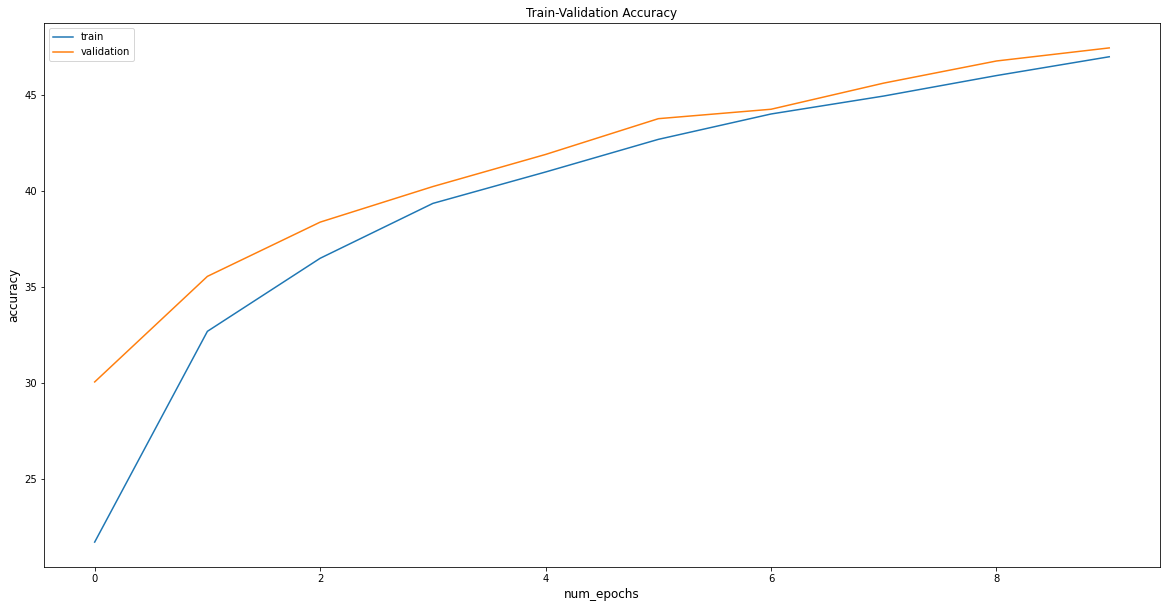

In [10]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

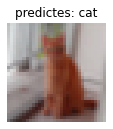

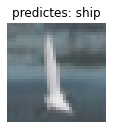

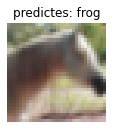

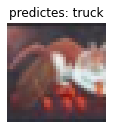

In [11]:
def visualize_model(net, num_images=4):
    images_so_far = 0
   # fig = plt.figure(figsize=(15, 6))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if use_cuda else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()

Conclusiones: El resultado de entrenar el modelo desde cero, arroja buenos resultados, pero con menor accuracy. Es decir, voy a necesitar más epochs que con el modelo preentrenado.